In [15]:
%pip install kaggle kagglehub pandas mathplot matplotlib scikit-learn numpy


Note: you may need to restart the kernel to use updated packages.


### Load the dataset

Loads the California Housing Dataset from Kaggle. 

In [16]:
import kagglehub
import pandas as pd
import os

# Download latest version
path = kagglehub.dataset_download("camnugent/california-housing-prices") # saved in cache

print("Path to dataset files:", path) 

def load_housing_data():
    # loaded to pandas
    return pd.read_csv(os.path.join(path, "housing.csv")) 

housing = load_housing_data()


Path to dataset files: /home/helenaschneider/.cache/kagglehub/datasets/camnugent/california-housing-prices/versions/1


In [4]:
print(housing.head())
print(housing.info())

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639

In [5]:
housing["ocean_proximity"].value_counts()
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


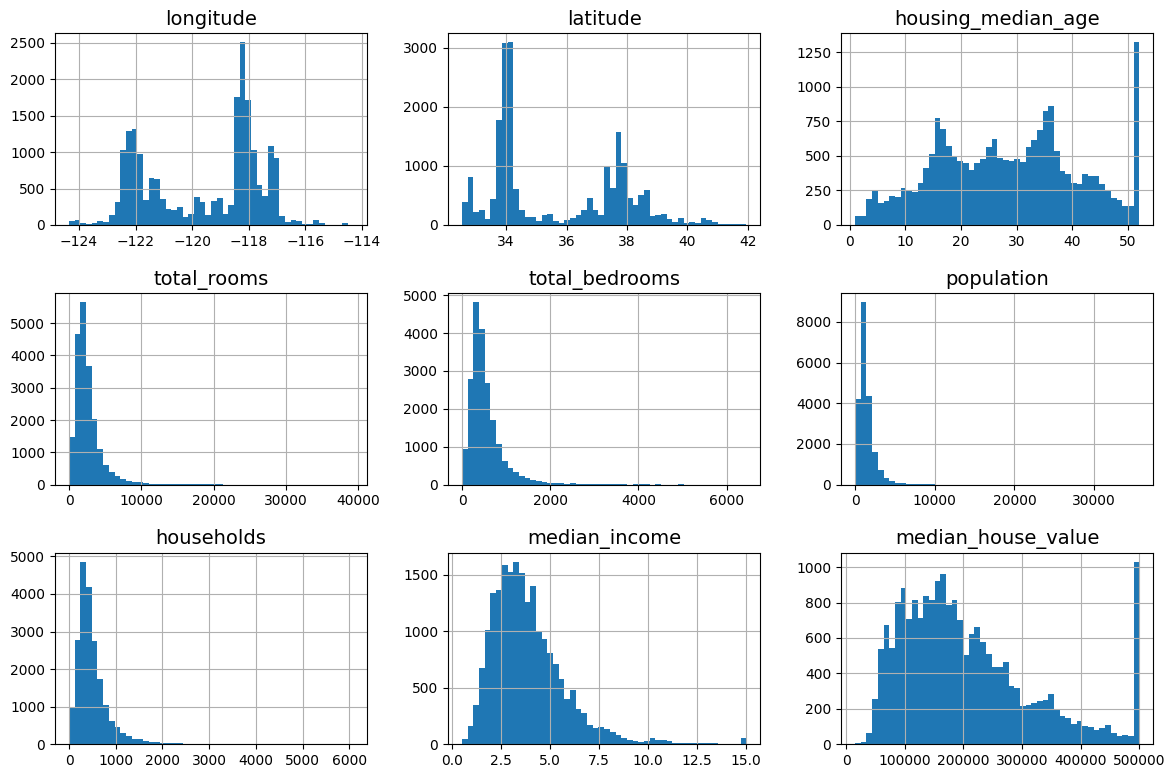

In [6]:
import matplotlib.pyplot as plt
from utils.figures import save_fig

# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(12, 8))
save_fig("attribute_histogram_plots")  # extra code
plt.show()

### Create Train-Test-Split

In [13]:
# set seed to ensure same output for multiple runs
random_seed = 3

In [14]:
from sklearn.model_selection import train_test_split

housing_with_id = housing.reset_index()
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=random_seed)

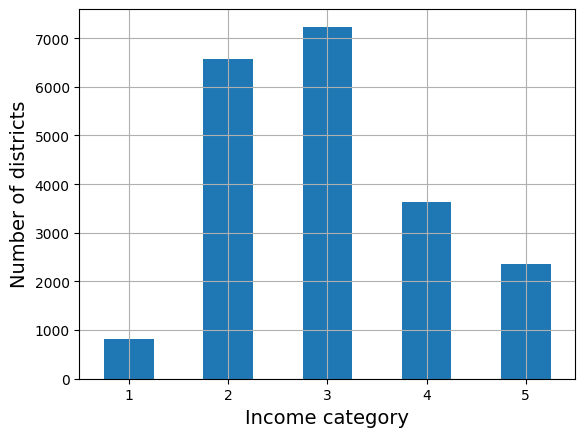

In [18]:
import numpy as np

# ensure instances from each median income stratum 
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [22]:
from sklearn.model_selection import StratifiedShuffleSplit

# use the stratisfied splitter
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [23]:
# income_cat not needed anymore
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [24]:
housing_copy = strat_train_set.copy()

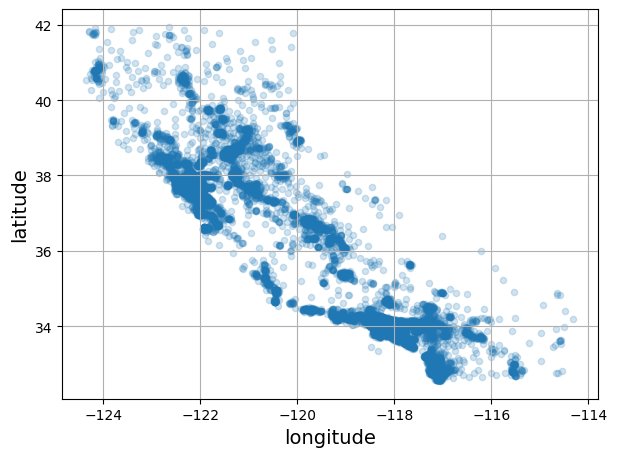

In [27]:
housing_copy.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
save_fig("geodata_scatterplot")
plt.show()

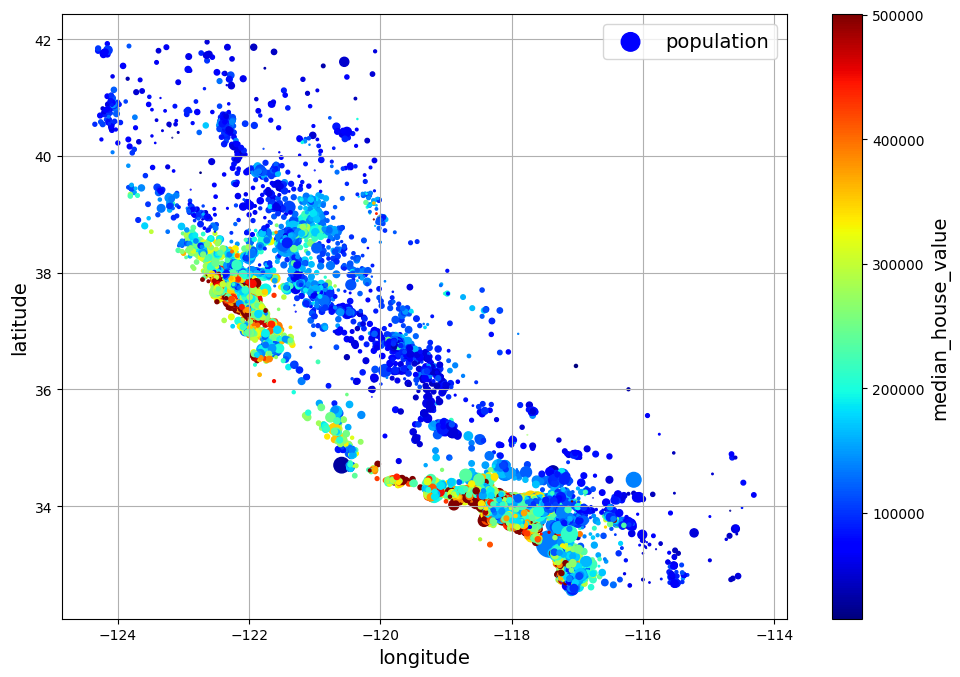

In [31]:
housing_copy.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing_copy["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
save_fig("price_population_per_district_scatterplot")
plt.show()

In [ ]:
def calc_corr(data):
    # Select only the numeric columns
    numeric_data = data.select_dtypes(include=[float, int])

    # Calculate the correlation matrix on the numeric data
    corr_matrix = numeric_data.corr()

    # Display the correlation matrix
    print(corr_matrix)

calc_corr(housing_copy)

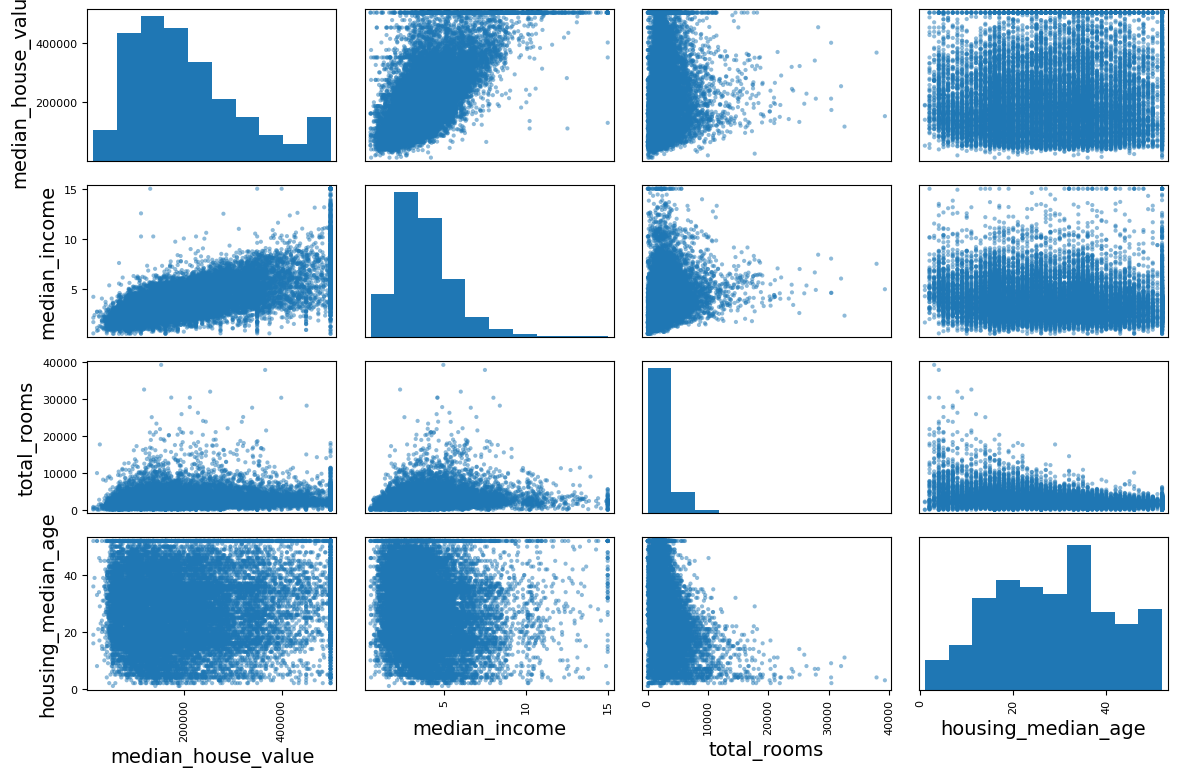

In [36]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_mix_plot")
plt.show()

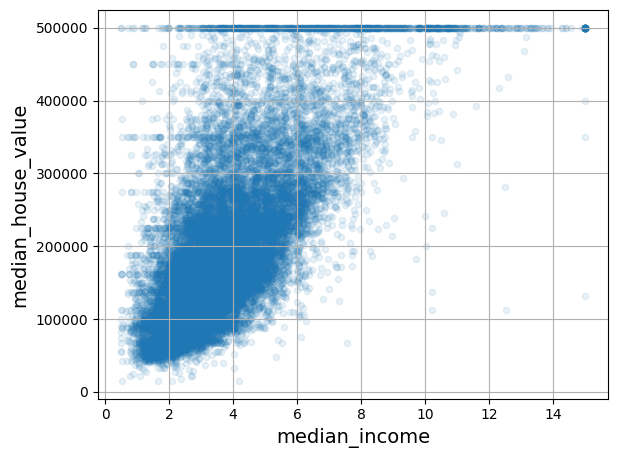

In [38]:
# check if median income is a good predictor for median house value
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)
save_fig("income_house_value_scatterplot")
plt.show()

### Preprocessing

In [39]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]